# **NFL First and Future Dataset**

### **Cleaning and Analysis**

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import seaborn as sns

Data Frame Capping 

In [2]:
# Get rid of Cap for EDA

# pd.set_option('display.max_columns', 14)
# pd.set_option('display.max_rows', 50)

# Put it Back

pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

#### **Import, Cleaning, and First-Analysis**

In [3]:
PlayerTrackData = pd.read_csv("/Users/leemcfarling/Documents/BU Grad School/Semester Two /AI for Leaders/NFL_Stats/SurfaceAnalytics/PlayerTrackData.csv")
InjuryRecord = pd.read_csv("/Users/leemcfarling/Documents/BU Grad School/Semester Two /AI for Leaders/NFL_Stats/SurfaceAnalytics/InjuryRecord.csv")
PlayList = pd.read_csv("/Users/leemcfarling/Documents/BU Grad School/Semester Two /AI for Leaders/NFL_Stats/SurfaceAnalytics/PlayList.csv")

In [4]:
print(f"There are {len(PlayerTrackData):,} rows in the Player Tracking Dataset.")
print(f"There are {len(InjuryRecord):,} rows in the Injury Record Dataset.")
print(f"There are {len(PlayList):,} rows in the Play List Dataset") 

There are 76,366,748 rows in the Player Tracking Dataset.
There are 105 rows in the Injury Record Dataset.
There are 267,005 rows in the Play List Dataset


In [5]:
# First putting all 'events' from the NGS dataframe, PlayerTrackData into an array. 

NGS_Events = PlayerTrackData['event'].unique()  
NGS_Events = pd.Series(NGS_Events) 
NGS_Events.str.contains('injur', case=False, na=False).sum()

# And then convert it to a series and see if "injured" or 'injury' are present

np.int64(1)

In [6]:
len(InjuryRecord) / len(PlayList) * 100

0.03932510627141814

#### **Next Gen Statistics Aggregation**
- Developed with help from ChatGPT -- https://chatgpt.com/share/67caff72-ebf0-800f-a1d6-e162bf42afab

In [7]:
def aggregate_player_tracking_data(df, group_cols, id_columns):
    pre_process = df.loc[
        df[id_columns].eq(df[id_columns].min()).all(axis=1)
    ]

    # Identify numeric columns, excluding the provided id_columns
    numeric_cols = [col for col in pre_process.select_dtypes(include=['number']).columns if col not in id_columns]

    # Function to return first non-null value in a group
    def first_non_nan(series):
        return series.dropna().iloc[0] if not series.dropna().empty else 'NA'

    # Aggregation rules
    agg_rules = {
        **{col: 'mean' for col in numeric_cols},  # Mean for numeric columns
        **{col: first_non_nan for col in id_columns},  # First valid value for ID columns
        **{col: first_non_nan for col in df.columns if col not in numeric_cols and col not in id_columns}  
    }

    result = df.groupby(group_cols).agg(agg_rules)
    result_post_process = result.drop(columns=group_cols, axis=1, errors='ignore')
    result_reset_index = result_post_process.reset_index()

    return result_reset_index

In [8]:
id_cols = ['PlayKey']  # ID columns
groupby_cols = ['PlayKey']  # Grouping columns
NGSWeekData = [PlayerTrackData]


NGSTrackData = aggregate_player_tracking_data(PlayerTrackData, groupby_cols, id_cols)
PlayerTrackData = NGSTrackData

First, let's start with the InjuryRecord dataFrame. Right now, there are four columns tracking injurise (it's been one-hot encoded). This might be good for a model, but it's not very helpful for EDA. Let's condense it into one column. 

In [9]:
InjuryRecord['InjuryLength'] = InjuryRecord[['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']].sum(axis=1)
injury_mapping = {1: "1+", 2: "7+", 3: "28+", 4: "42+"}
InjuryRecord['InjuryLength'] = InjuryRecord['InjuryLength'].map(injury_mapping).astype(str)
InjuryRecord

PlayerKey    GameID     PlayKey BodyPart    Surface  DM_M1  DM_M7  \
0        39873   39873-4  39873-4-32     Knee  Synthetic      1      1   
1        46074   46074-7  46074-7-26     Knee    Natural      1      1   
2        36557   36557-1  36557-1-70    Ankle  Synthetic      1      1   
3        46646   46646-3  46646-3-30    Ankle    Natural      1      0   
4        43532   43532-5  43532-5-69    Ankle  Synthetic      1      1   
..         ...       ...         ...      ...        ...    ...    ...   
100      44423  44423-13         NaN     Knee  Synthetic      1      0   
101      31933  31933-20         NaN     Knee  Synthetic      1      0   
102      47285   47285-4         NaN     Knee    Natural      1      1   
103      37068  37068-19         NaN     Knee    Natural      1      1   
104      36696  36696-24         NaN     Knee  Synthetic      1      1   

     DM_M28  DM_M42 InjuryLength  
0         1       1          42+  
1         0       0           7+  
2         1       1          42+  
3         0       0           1+  
4         1       1          42+  
..      ...     ...          ...  
100       0       0           1+  
101       0       0           1+  
102       0       0           7+  
103       0       0           7+  
104       0       0           7+  

[105 rows x 10 columns]

Next, there are player tracking metrics that have been aggressively abrieviated. We can change the naming of these columns so that they are more intuitive for this analysis.

In [10]:
PlayerTrackData1 = PlayerTrackData.loc[PlayerTrackData.groupby('PlayKey')['time'].idxmax()]
PlayerTrackData1 = PlayerTrackData1.rename(columns={'dir': 'direction', 's': 'speed', 'dis': 'distance'})

Next, the stadium mapping and Weather columns are not formatted very well. We can use a dictionary to condense these dozens of related stadium and weather types into more simplistic categories. 

In [11]:
stadium_mapping = {
    "Outdoor": "Outdoors",
    "Oudoor": "Outdoors",
    "Outdoors": "Outdoors",
    "Open": "Outdoors",
    "Outdoor Retr Roof": "Outdoors",
    "Oudoor": "Outdoors",
    "Outddors": "Outdoors",
    "Retr. Roof-Open": "Outdoors",
    "Retr. Roof - Open": "Outdoors",
    "Outdor": "Outdoors",
    "Outside": "Outdoors",
    "Heinz Field": "Outdoors",
    "Cloudy": "Outdoors",
    "Outdoor Retr Roof-Open" : "Outdoors", 
    "Ourdoor" : "Outdoors",
    "Indoor, Open Roof" : "Outdoors",

    "Indoors": "Indoors",
    "Closed Dome": "Indoors",
    "Domed": "Indoors",
    "closed": "Indoors",
    "Dome": "Indoors",
    "Indoor": "Indoors",
    "Retr. Roof-Closed": "Indoors",
    "Retr. Roof - Closed": "Indoors",
    "Retractable Roof": "Indoors",
    "Domed, Open": "Indoors",
    "Domed, open": "Indoors",
    "Roof Closed": "Indoors",
    "Dome, closed": "Indoors",
    "Domed, closed" : "Indoors",
    "Indoor, Roof Closed": "Indoors", 
    "Retr. Roof Closed": "Indoors",

    "nan": "Unknown",
    "Bowl": "Unknown"
}

PlayList['StadiumType'] = PlayList['StadiumType'].replace(stadium_mapping)
PlayList['StadiumType'] = PlayList['StadiumType'].replace(stadium_mapping).fillna("Unknown")

print(PlayList['StadiumType'].unique())

['Outdoors' 'Indoors' 'Unknown']


And for weather. 

In [12]:
PlayList['Weather'].unique()


array(['Clear and warm', 'Mostly Cloudy', 'Sunny', 'Clear', 'Cloudy',
       'Cloudy, fog started developing in 2nd quarter', 'Rain',
       'Partly Cloudy', 'Mostly cloudy', 'Cloudy and cold',
       'Cloudy and Cool', 'Rain Chance 40%', 'Controlled Climate',
       'Sunny and warm', 'Partly cloudy', 'Clear and Cool',
       'Clear and cold', 'Sunny and cold', 'Indoor', nan, 'Partly Sunny',
       'N/A (Indoors)', 'Mostly Sunny', 'Indoors', 'Clear Skies',
       'Partly sunny', 'Showers', 'N/A Indoor', 'Sunny and clear', 'Snow',
       'Scattered Showers', 'Party Cloudy', 'Clear skies',
       'Rain likely, temps in low 40s.', 'Hazy', 'Partly Clouidy',
       'Sunny Skies', 'Overcast', 'Cloudy, 50% change of rain', 'Fair',
       'Light Rain', 'Partly clear', 'Mostly Coudy', '10% Chance of Rain',
       'Cloudy, chance of rain', 'Heat Index 95',
       'Sunny, highs to upper 80s', 'Sun & clouds',
       'Heavy lake effect snow', 'Mostly sunny', 'Cloudy, Rain',
       'Sunny, Windy', '

In [13]:
weather_mapping = {
    # Sunny
    "Clear and warm": "Sunny",
    "Sunny": "Sunny",
    "Clear": "Sunny",
    "Clear Skies": "Sunny",
    "Clear and Cool": "Sunny",
    "Clear and Sunny": "Sunny",
    "Clear and cold": "Sunny",
    "Fair": "Sunny",
    "Sunny and cold": "Sunny",
    "Mostly Sunny": "Sunny",
    "Clear skies": "Sunny",
    "Sunny Skies": "Sunny",
    "Sunny and warm": "Sunny",
    "Sunny and clear": "Sunny",
    "Sunny, Windy": "Sunny",
    "Sunny, highs to upper 80s": "Sunny", 
    "Clear and sunny": "Sunny",

    # Partly Cloudy
    "Partly cloudy": "Partly Cloudy",
    "Mostly Sunny Skies": "Partly Cloudy",
    "Mostly sunny": "Partly Cloudy",
    "Partly Sunny": "Partly Cloudy",
    "Partly sunny": "Partly Cloudy",
    "Party Cloudy": "Partly Cloudy",
    "Partly Cloudy": "Partly Cloudy",
    "Partly clear": "Partly Cloudy",
    "Sun & clouds": "Partly Cloudy",
    "Clear to Partly Cloudy": "Partly Cloudy",
    "Partly Clouidy" : "Partly Cloudy",

    # Cloudy
    "Cloudy": "Cloudy",
    "Cloudy and cold": "Cloudy",
    "Mostly Cloudy": "Cloudy",
    "Cloudy and Cool": "Cloudy",
    "Mostly Coudy": "Cloudy",
    "cloudy": "Cloudy",
    "Coudy": "Cloudy",
    "Mostly cloudy": "Cloudy",
    "Overcast": "Cloudy",
    "Cloudy, chance of rain" : "Cloudy" ,   

    # Rain
    "Scattered Showers" : "Rain",
    "Rainy": "Rain",
    "Rain": "Rain",
    "Rain Chance 40%": "Rain",
    "Showers": "Rain",
    "30% Chance of Rain": "Rain",
    "Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.": "Rain",
    "Light Rain": "Rain",
    "chance of rain": "Rain",
    "Rain shower": "Rain",
    "Rain likely": "Rain",
    "Rain likely, temps in low 40s." : "Rain",
    "Cloudy, 50% change of rain" : "Rain",
    "Cloudy, Rain": "Rain",
    "50% change of rain": "Rain",
    "10% Chance of Rain": "Rain",
    "Cloudy with periods of rain": "Rain",

    # Snow
    "Snow": "Snow",
    "Heavy lake effect snow": "Snow",
    "light snow accumulating 1-3": "Snow",
    "Cloudy, light snow accumulating 1-3": "Snow", 
    'Cloudy, light snow accumulating 1-3"': "Snow",

    # Fog
    "Cloudy, fog started developing in 2nd quarter": "Fog",
    "Hazy": "Fog",
    

    # Unknown
    "nan": "Unknown",
    "temps in low 40s.": "Unknown",
    "Heat Index 95": "Unknown",
    "highs to upper 80s": "Unknown",
    "Cold": "Unknown",

    # N/A Indoors
    "N/A (Indoors)": "N/A (Indoors)",
    "Controlled Climate": "N/A (Indoors)",
    "N/A Indoor": "N/A (Indoors)",
    "Indoor": "N/A (Indoors)",
    "Indoors": "N/A (Indoors)"
}

PlayList['Weather'] = PlayList['Weather'].replace(weather_mapping).fillna("Unknown")
print(PlayList['Weather'].unique())

['Sunny' 'Cloudy' 'Fog' 'Rain' 'Partly Cloudy' 'N/A (Indoors)' 'Unknown'
 'Snow']


In [14]:
PlayList['PlayType'].unique()

array(['Pass', 'Rush', '0', nan, 'Kickoff', 'Kickoff Not Returned',
       'Field Goal', 'Punt', 'Punt Not Returned', 'Punt Returned',
       'Kickoff Returned', 'Extra Point'], dtype=object)

In [15]:
PlayTypeMapping = {
    "0" : "Unknown",
    "nan" : "Unknown",

    # Kickoff
    "Kickoff Not Returned" : "Kickoff",
    "Kickoff Returned" : "Kickoff",

    # Punt
    "Punt Not Returned" : "Punt",
    "Punt Returned": "Punt",
}
PlayList['PlayType'] = PlayList['PlayType'].replace(PlayTypeMapping).fillna("Unknown")
PlayList['PlayType'].unique()

array(['Pass', 'Rush', 'Unknown', 'Kickoff', 'Field Goal', 'Punt',
       'Extra Point'], dtype=object)

In [16]:
PositionGroupMapping = {
    "QB" : "QuarterBack",
    "Missing Data" : "Unknown",
    "WR" : "WideReciever",
    "LB" : "LineBacker",
    "RB" : "RunningBack",
    "DL" : "DefensiveLine",
    "TE" : "TightEnd",
    "DB" : "DefensiveBack",
    "OL" : "OffensiveLine",
    "SPEC" : "SpecialTeams"
}



PlayList['PositionGroup'] = PlayList['PositionGroup'].replace(PositionGroupMapping)
PlayList['PositionGroup'].unique()



array(['QuarterBack', 'Unknown', 'WideReciever', 'LineBacker',
       'RunningBack', 'DefensiveLine', 'TightEnd', 'DefensiveBack',
       'OffensiveLine', 'SpecialTeams'], dtype=object)

And we uncovered some temps that were set to -999 degrees. Let's replace those with the median Temperature Value instead. 

In [17]:
PlayList[['Temperature']].median()

PlayList_Temp_Map = {
    -999 : 61.0
}

PlayList['Temperature'] = PlayList['Temperature'].replace(PlayList_Temp_Map)
PlayList.query("Temperature < -100")

Empty DataFrame
Columns: [PlayerKey, GameID, PlayKey, RosterPosition, PlayerDay, PlayerGame, StadiumType, FieldType, Temperature, Weather, PlayType, PlayerGamePlay, Position, PositionGroup]
Index: []

Finally, the data is organized into three CSVs so we should attempt to merge the three into one dataframe. 

In [18]:
Merged_Injury = InjuryRecord[['PlayKey', 'BodyPart', 'Surface', 'InjuryLength', ]].merge(
    PlayList[['PlayKey', 'PlayerKey', 'PlayerDay', 'PlayerGame', 'StadiumType', 'FieldType', 'Temperature', 'Weather', 'PlayType', 'PlayerGamePlay', 'Position', 'PositionGroup']], 
    how='inner', 
    on=['PlayKey']).merge(PlayerTrackData1[['PlayKey', 'x', 'y', 'direction', 'speed', 'distance', 'time']], how='inner', on='PlayKey')

Merged_Injury_pre = Merged_Injury.query("~InjuryLength.isna()").index
Merged_Injury['Inj_Occured'] = np.where(Merged_Injury.index.isin(Merged_Injury_pre), 1, 0)
Merged_Injury

PlayKey BodyPart    Surface InjuryLength  PlayerKey  PlayerDay  \
0    39873-4-32     Knee  Synthetic          42+      39873         29   
1    46074-7-26     Knee    Natural           7+      46074         50   
2    36557-1-70    Ankle  Synthetic          42+      36557          1   
3    46646-3-30    Ankle    Natural           1+      46646         15   
4    43532-5-69    Ankle  Synthetic          42+      43532         32   
..          ...      ...        ...          ...        ...        ...   
72  42418-19-15    Ankle  Synthetic           1+      42418        442   
73   46394-18-3     Knee  Synthetic           7+      46394        393   
74    45187-9-4    Ankle    Natural           1+      45187        327   
75   42448-14-3     Knee  Synthetic          28+      42448        379   
76    47334-8-1     Knee  Synthetic           7+      47334         58   

    PlayerGame StadiumType  FieldType  Temperature  ... PlayerGamePlay  \
0            4     Indoors  Synthetic           84  ...             32   
1            7    Outdoors    Natural           76  ...             26   
2            1    Outdoors  Synthetic           63  ...             70   
3            3    Outdoors    Natural           80  ...             30   
4            5     Indoors  Synthetic           89  ...             69   
..         ...         ...        ...          ...  ...            ...   
72          19     Indoors  Synthetic           57  ...             15   
73          18    Outdoors  Synthetic           45  ...              3   
74           9    Outdoors    Natural           81  ...              4   
75          14     Indoors  Synthetic           78  ...              3   
76           8     Indoors  Synthetic           74  ...              1   

   Position  PositionGroup          x          y   direction     speed  \
0       OLB     LineBacker  70.364027  29.741018  189.061222  1.489140   
1       OLB     LineBacker  65.712646  26.073991  144.081300  2.024215   
2        SS  DefensiveBack  79.455250  23.267500  156.608563  1.574938   
3        LB     LineBacker  50.998280  26.180320  126.469440  2.194320   
4        WR   WideReciever  65.598514  46.844857  164.235943  0.760543   
..      ...            ...        ...        ...         ...       ...   
72        C  OffensiveLine  59.343956  23.616075  214.237321  0.654237   
73       TE       TightEnd  56.389781  41.013443  217.776175  2.673880   
74       WR   WideReciever  16.601672  16.926972  138.652555  1.616782   
75       WR   WideReciever  53.226865   7.361027  147.681135  2.284649   
76       DB  DefensiveBack  56.815567  34.524381  240.235567  3.588093   

    distance   time  Inj_Occured  
0   0.160837  22.05            1  
1   0.210269  11.10            1  
2   0.168875   7.95            1  
3   0.237160  12.45            1  
4   0.087743  17.45            1  
..       ...    ...          ...  
72  0.068380  16.00            1  
73  0.267596  18.25            1  
74  0.163943  15.80            1  
75  0.233351   9.20            1  
76  0.359691   9.65            1  

[77 rows x 22 columns]

In [19]:
Merged_Injury[Merged_Injury['PlayType'].str.contains("Punt")]

PlayKey BodyPart    Surface InjuryLength  PlayerKey  PlayerDay  \
0    39873-4-32     Knee  Synthetic          42+      39873         29   
1    46074-7-26     Knee    Natural           7+      46074         50   
3    46646-3-30    Ankle    Natural           1+      46646         15   
18   46119-3-16     Knee    Natural           7+      46119         15   
32    38228-1-4    Ankle  Synthetic           7+      38228          1   
34   45950-8-18    Ankle    Natural           1+      45950         71   
39    42637-3-6     Knee    Natural          42+      42637         12   
40    46430-8-6     Knee    Natural           7+      46430         71   
43    39850-9-2     Knee  Synthetic          42+      39850         64   
49   47235-7-55     Foot  Synthetic          28+      47235         50   
53  42398-15-33     Knee  Synthetic          42+      42398        396   
56   47813-8-19    Ankle  Synthetic           7+      47813         78   
60  38876-29-14    Ankle    Natural           7+      38876        471   

    PlayerGame StadiumType  FieldType  Temperature  ... PlayerGamePlay  \
0            4     Indoors  Synthetic           84  ...             32   
1            7    Outdoors    Natural           76  ...             26   
3            3    Outdoors    Natural           80  ...             30   
18           3    Outdoors    Natural           89  ...             16   
32           1    Outdoors  Synthetic           65  ...              4   
34           8    Outdoors    Natural           38  ...             18   
39           3    Outdoors    Natural           33  ...              6   
40           8    Outdoors    Natural           38  ...              6   
43           9    Outdoors  Synthetic           47  ...              2   
49           7    Outdoors  Synthetic           55  ...             55   
53          15     Unknown  Synthetic           70  ...             33   
56           8    Outdoors  Synthetic           44  ...             19   
60          29    Outdoors    Natural           58  ...             14   

   Position  PositionGroup          x          y   direction     speed  \
0       OLB     LineBacker  70.364027  29.741018  189.061222  1.489140   
1       OLB     LineBacker  65.712646  26.073991  144.081300  2.024215   
3        LB     LineBacker  50.998280  26.180320  126.469440  2.194320   
18      OLB     LineBacker  40.551116  36.837934  192.997975  2.946942   
32      ILB     LineBacker  69.170478  17.691660  208.129662  0.693668   
34       FS  DefensiveBack  78.368673   5.983837  210.967592  1.075898   
39      OLB     LineBacker  50.238947  34.207579  142.320632  2.723947   
40      MLB     LineBacker  71.866552  15.881609  172.885287  2.610345   
43       SS  DefensiveBack  43.960625   9.160156  158.534922  1.678438   
49       CB  DefensiveBack  62.924626  11.176429  202.932857  2.160918   
53       WR   WideReciever  69.989581   9.370785  122.655916  3.498953   
56       CB  DefensiveBack  61.980846  24.385821  176.124328  3.334876   
60       WR   WideReciever  51.399660  34.638883  119.859126  3.074369   

    distance   time  Inj_Occured  
0   0.160837  22.05            1  
1   0.210269  11.10            1  
3   0.237160  12.45            1  
18  0.309298  12.05            1  
32  0.075629  53.25            1  
34  0.111714  24.45            1  
39  0.279842   9.45            1  
40  0.270920  13.00            1  
43  0.177734  12.75            1  
49  0.218027  14.65            1  
53  0.350366   9.50            1  
56  0.336965  10.00            1  
60  0.308252  10.25            1  

[13 rows x 22 columns]

And finally, I want to get a picture of the plays that occured -- not just the plays that resulted in Injury. 

In [20]:
All_Plays = InjuryRecord[['PlayKey', 'BodyPart', 'Surface', 'InjuryLength']].merge(
    PlayList[['PlayKey', 'PlayerKey', 'PlayerDay', 'PlayerGame', 'StadiumType', 'FieldType', 'Temperature', 'Weather', 'PlayType', 'PlayerGamePlay', 'Position', 'PositionGroup']], 
    how='right', 
    on=['PlayKey']).merge(PlayerTrackData1[['PlayKey', 'x', 'y', 'direction', 'speed', 'distance', 'time']], how='left', on='PlayKey')

# Now create a column for each play that had an Injury. 
PlaysWithInjuries = All_Plays.query("~InjuryLength.isna()").index
All_Plays['Inj_Occured'] = np.where(All_Plays.index.isin(PlaysWithInjuries), 1, 0)
All_Plays

PlayKey BodyPart Surface InjuryLength  PlayerKey  PlayerDay  \
0         26624-1-1      NaN     NaN          NaN      26624          1   
1         26624-1-2      NaN     NaN          NaN      26624          1   
2         26624-1-3      NaN     NaN          NaN      26624          1   
3         26624-1-4      NaN     NaN          NaN      26624          1   
4         26624-1-5      NaN     NaN          NaN      26624          1   
...             ...      ...     ...          ...        ...        ...   
267001  47888-13-51      NaN     NaN          NaN      47888         99   
267002  47888-13-52      NaN     NaN          NaN      47888         99   
267003  47888-13-53      NaN     NaN          NaN      47888         99   
267004  47888-13-54      NaN     NaN          NaN      47888         99   
267005  47888-13-55      NaN     NaN          NaN      47888         99   

        PlayerGame StadiumType  FieldType  Temperature  ... PlayerGamePlay  \
0                1    Outdoors  Synthetic           63  ...              1   
1                1    Outdoors  Synthetic           63  ...              2   
2                1    Outdoors  Synthetic           63  ...              3   
3                1    Outdoors  Synthetic           63  ...              4   
4                1    Outdoors  Synthetic           63  ...              5   
...            ...         ...        ...          ...  ...            ...   
267001          13    Outdoors  Synthetic           33  ...             51   
267002          13    Outdoors  Synthetic           33  ...             52   
267003          13    Outdoors  Synthetic           33  ...             53   
267004          13    Outdoors  Synthetic           33  ...             54   
267005          13    Outdoors  Synthetic           33  ...             55   

       Position  PositionGroup          x          y   direction     speed  \
0            QB    QuarterBack  87.665753  28.221104  186.148361  0.535753   
1            QB    QuarterBack  86.616462  29.144077  211.949423  0.849692   
2            QB    QuarterBack  79.677264  28.900203  194.134122  0.331014   
3            QB    QuarterBack  72.469449  26.680157  163.762205  0.523701   
4            QB    QuarterBack  65.407846  24.865577  222.120577  0.970385   
...         ...            ...        ...        ...         ...       ...   
267001       DB  DefensiveBack  41.700296  18.853989  155.077709  1.229191   
267002       DB  DefensiveBack  53.980678  18.102780  169.963559  1.796203   
267003       DB  DefensiveBack  57.170638  10.130479  181.141330  1.806649   
267004       DB  DefensiveBack  54.662095  18.973687  166.529609  2.147682   
267005       DB  DefensiveBack  73.845399  25.883113  190.421322  1.465234   

        distance   time  Inj_Occured  
0       0.056288  14.90            0  
1       0.090077  12.95            0  
2       0.036081  14.75            0  
3       0.054016   6.30            0  
4       0.099769  12.95            0  
...          ...    ...          ...  
267001  0.124582  18.50            0  
267002  0.180780  14.70            0  
267003  0.182394   9.35            0  
267004  0.215279  17.85            0  
267005  0.147521  18.10            0  

[267006 rows x 22 columns]

In [21]:
All_Plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267006 entries, 0 to 267005
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PlayKey         267006 non-null  object 
 1   BodyPart        77 non-null      object 
 2   Surface         77 non-null      object 
 3   InjuryLength    77 non-null      object 
 4   PlayerKey       267006 non-null  int64  
 5   PlayerDay       267006 non-null  int64  
 6   PlayerGame      267006 non-null  int64  
 7   StadiumType     267006 non-null  object 
 8   FieldType       267006 non-null  object 
 9   Temperature     267006 non-null  int64  
 10  Weather         267006 non-null  object 
 11  PlayType        267006 non-null  object 
 12  PlayerGamePlay  267006 non-null  int64  
 13  Position        267006 non-null  object 
 14  PositionGroup   267006 non-null  object 
 15  x               266961 non-null  float64
 16  y               266961 non-null  float64
 17  direction 

In [22]:
All_Plays.describe()

PlayerKey     PlayerDay     PlayerGame    Temperature  \
count  267006.000000  267006.00000  267006.000000  267006.000000   
mean    41515.403156     210.45084      13.799117      60.924500   
std      4125.866422     183.64350       8.342881      16.761277   
min     26624.000000     -62.00000       1.000000       9.000000   
25%     39653.000000      43.00000       7.000000      49.000000   
50%     42432.000000     102.00000      13.000000      61.000000   
75%     44480.000000     400.00000      20.000000      72.000000   
max     47888.000000     480.00000      32.000000      97.000000   

       PlayerGamePlay              x              y      direction  \
count   267006.000000  266961.000000  266961.000000  266961.000000   
mean        29.058605      60.166875      26.750706     179.785242   
std         19.626526      24.171689       7.334212      33.948371   
min          1.000000       1.399103      -2.746723      27.642222   
25%         13.000000      41.297183      22.260318     157.408105   
50%         26.000000      60.272779      26.757130     179.787035   
75%         43.000000      79.023519      31.235804     202.193528   
max        102.000000     123.406408      56.803038     329.506753   

               speed       distance           time    Inj_Occured  
count  266961.000000  266961.000000  266961.000000  267006.000000  
mean        1.327123       0.137822      14.265426       0.000288  
std         0.730753       0.072964       6.045665       0.016979  
min         0.000000       0.000000       0.250000       0.000000  
25%         0.821243       0.087468      10.800000       0.000000  
50%         1.198746       0.124801      13.600000       0.000000  
75%         1.661894       0.170861      16.500000       0.000000  
max         9.059091       0.914848      93.450000       1.000000

____

# **Univariate Analysis**

#### **Null Value Counts**
Taken from Module 3 - Week 3 

In [23]:
# This function will list how many nulls occur in which features

def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:.2f}%   {row['Type']}")

show_null_counts_features(All_Plays)

The dataset contains 267006 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
BodyPart        266929       99.97%   Categorical
Surface         266929       99.97%   Categorical
InjuryLength    266929       99.97%   Categorical
x               45           0.02%   Numeric
y               45           0.02%   Numeric
direction       45           0.02%   Numeric
speed           45           0.02%   Numeric
distance        45           0.02%   Numeric
time            45           0.02%   Numeric


This makes sense -- BodyPart, Surface, and InjuryLength are only filled out if there is an injury. And Injuries only occur 00.03% of the time.

#### **Duplicates**

Duplicate Rows

In [24]:
All_Plays.duplicated().sum()

np.int64(0)

____

#### **Duplicates in each column:**

First let's get a count of how many duplicated values are in each column:

In [25]:
def show_duplicates_per_column(df):
    duplicate_data = []

    for col in df.columns:
        duplicate_counts = df.groupby(col).size().reset_index(name='Count')
        duplicate_counts = duplicate_counts[duplicate_counts["Count"] > 1]

        if not duplicate_counts.empty:
            duplicate_data.append({
                'Feature': col,
                '# Duplicates': duplicate_counts["Count"].sum() - len(duplicate_counts),
                'Unique Duplicated Values': len(duplicate_counts),
                'Type': 'Numeric' if np.issubdtype(df[col].dtype, np.number) else 'Categorical'
            })

    print(f'The dataset contains {len(df)} samples.\n')

    if not duplicate_data:
        print("There are no duplicate values in the dataset!")
    else:
        duplicate_df = pd.DataFrame(duplicate_data).sort_values(by='# Duplicates', ascending=False)

        print('Feature Name    # Duplicates   Unique Duplicated Values    Type')
        print('------------    -----------   ----------------------    ----')
        for _, row in duplicate_df.iterrows():
            print(f"{row['Feature']:<15} {row['# Duplicates']:<14} {row['Unique Duplicated Values']:<24} {row['Type']}")

show_duplicates_per_column(All_Plays)

The dataset contains 267006 samples.

Feature Name    # Duplicates   Unique Duplicated Values    Type
------------    -----------   ----------------------    ----
Inj_Occured     267004         2                        Numeric
FieldType       267004         2                        Categorical
StadiumType     267003         3                        Categorical
PlayType        266999         7                        Categorical
Weather         266998         8                        Categorical
PositionGroup   266996         10                       Categorical
Position        266983         23                       Categorical
PlayerGame      266974         32                       Numeric
Temperature     266928         78                       Numeric
PlayerGamePlay  266904         102                      Numeric
PlayerDay       266791         215                      Numeric
PlayerKey       266756         250                      Numeric
time            261082         1220          

In [26]:
def duplicates_per_column(df):
    for col in df.columns: 
        duplicate_counts = df.groupby(col).size().reset_index(name='Count')
        duplicate_counts = duplicate_counts[duplicate_counts["Count"] > 1]

        if duplicate_counts.empty: 
            print(f"No Duplicates in {col}")
        else:
            print(f"Duplicates found in: {col}")
            print(duplicate_counts)
            print()
            print()

And then drilling into the specific Values that were duplicated in each Column, we have:

In [27]:
duplicates_per_column(All_Plays)

Duplicates found in: PlayKey
            PlayKey  Count
262059  47307-10-18      2


Duplicates found in: BodyPart
  BodyPart  Count
0    Ankle     35
1     Foot      6
2     Knee     36


Duplicates found in: Surface
     Surface  Count
0    Natural     36
1  Synthetic     41


Duplicates found in: InjuryLength
  InjuryLength  Count
0           1+     17
1          28+      7
2          42+     24
3           7+     29


Duplicates found in: PlayerKey
     PlayerKey  Count
0        26624   2207
1        27363   2011
2        30068   1946
3        30953    998
4        31070    278
..         ...    ...
245      47550    351
246      47784    423
247      47813    285
248      47820    184
249      47888    444

[250 rows x 2 columns]


Duplicates found in: PlayerDay
     PlayerDay  Count
0          -62    619
1          -55    696
2          -48    786
3          -44    576
4          -41    207
..         ...    ...
210        472     63
211        473    952
212        476   1115
21

___

## **Histograms**

In [28]:
All_Plays_Numeric = All_Plays.select_dtypes(include=['number']) # .drop(columns=['GameKey', 'PlayId'])
All_Plays_Categorical = All_Plays.select_dtypes(exclude=['number'])
Merged_Injury_Numeric = Merged_Injury.select_dtypes(include=['number'])
Merged_Injury_Categorical = Merged_Injury.select_dtypes(exclude=['number'])

In [29]:
def hist_for_numeric_data(df):
    
    df.hist(figsize=(12, 10))
    plt.tight_layout()

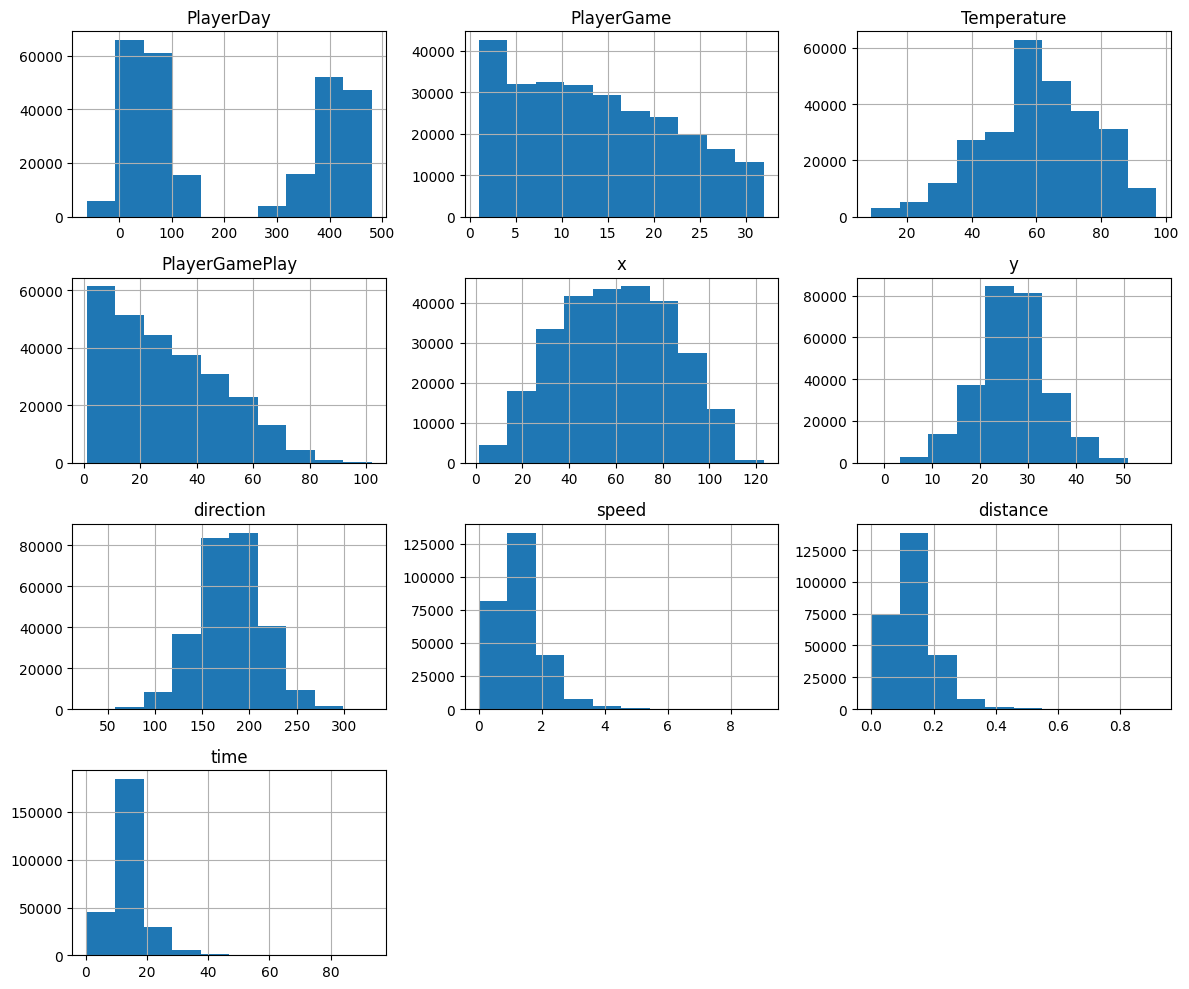

In [30]:
hist_all_plays = All_Plays_Numeric[['PlayerDay', 'PlayerGame', 'Temperature', 'PlayerGamePlay', 'x', 'y', 'direction', 'speed', 'distance', 'time']]
hist_for_numeric_data(hist_all_plays)

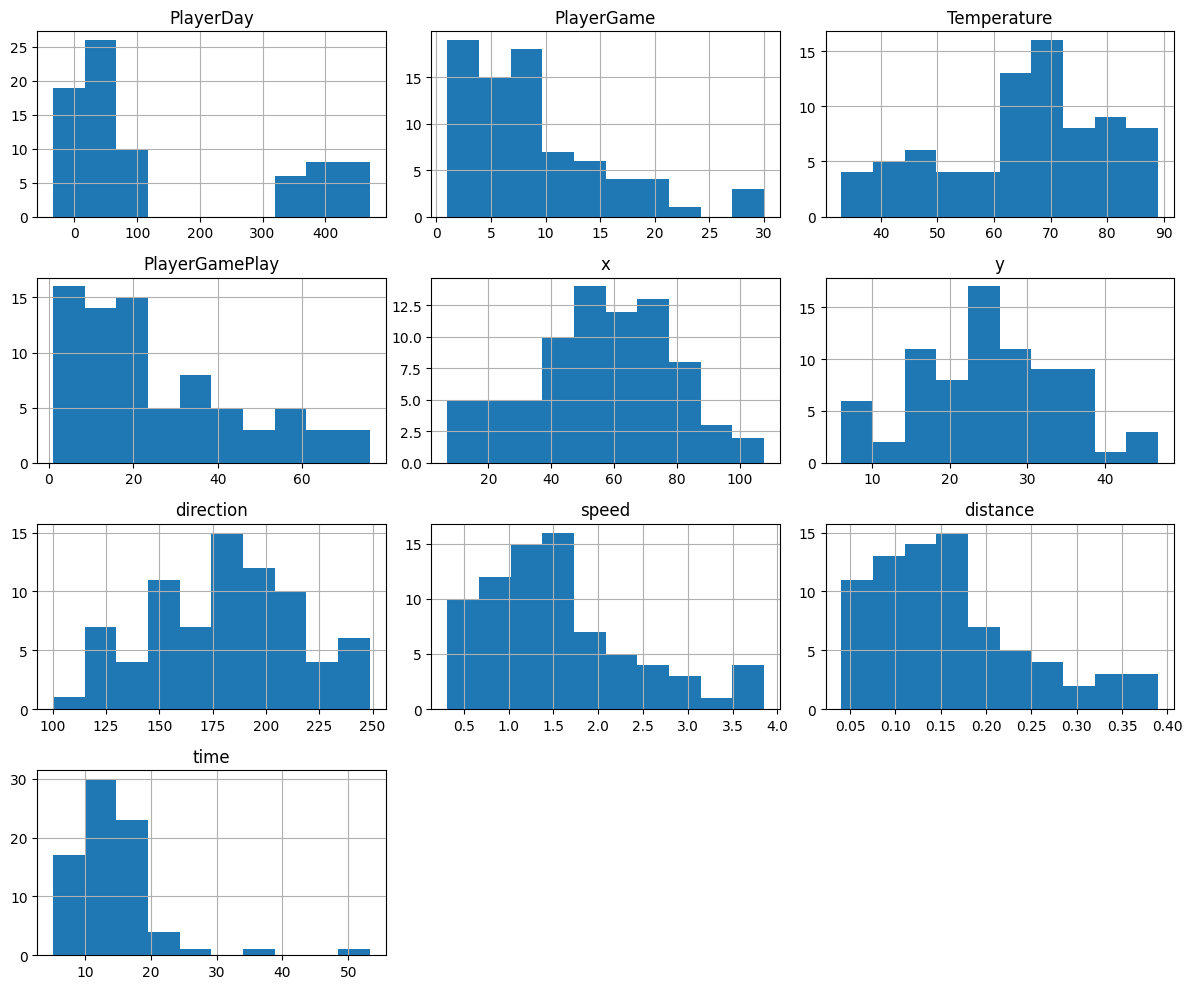

In [31]:
hist_inj_plays = Merged_Injury_Numeric[['PlayerDay', 'PlayerGame', 'Temperature', 'PlayerGamePlay', 'x', 'y', 'direction', 'speed', 'distance', 'time']]
hist_for_numeric_data(hist_inj_plays)

#### **BoxPlots**

In [32]:
def boxplots(df):
    num_cols = len(df.columns)  
    rows = 3  
    cols = 4  
    total_plots = min(num_cols, rows * cols)  
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))  
    axes = axes.flatten()  

    for i, col in enumerate(df.columns[:total_plots]):  
        df.boxplot(column=col, ax=axes[i]) 
        axes[i].set_title(f"Boxplot for {col}")  

    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j]) 

    plt.tight_layout()  
    plt.show()

#### All Plays

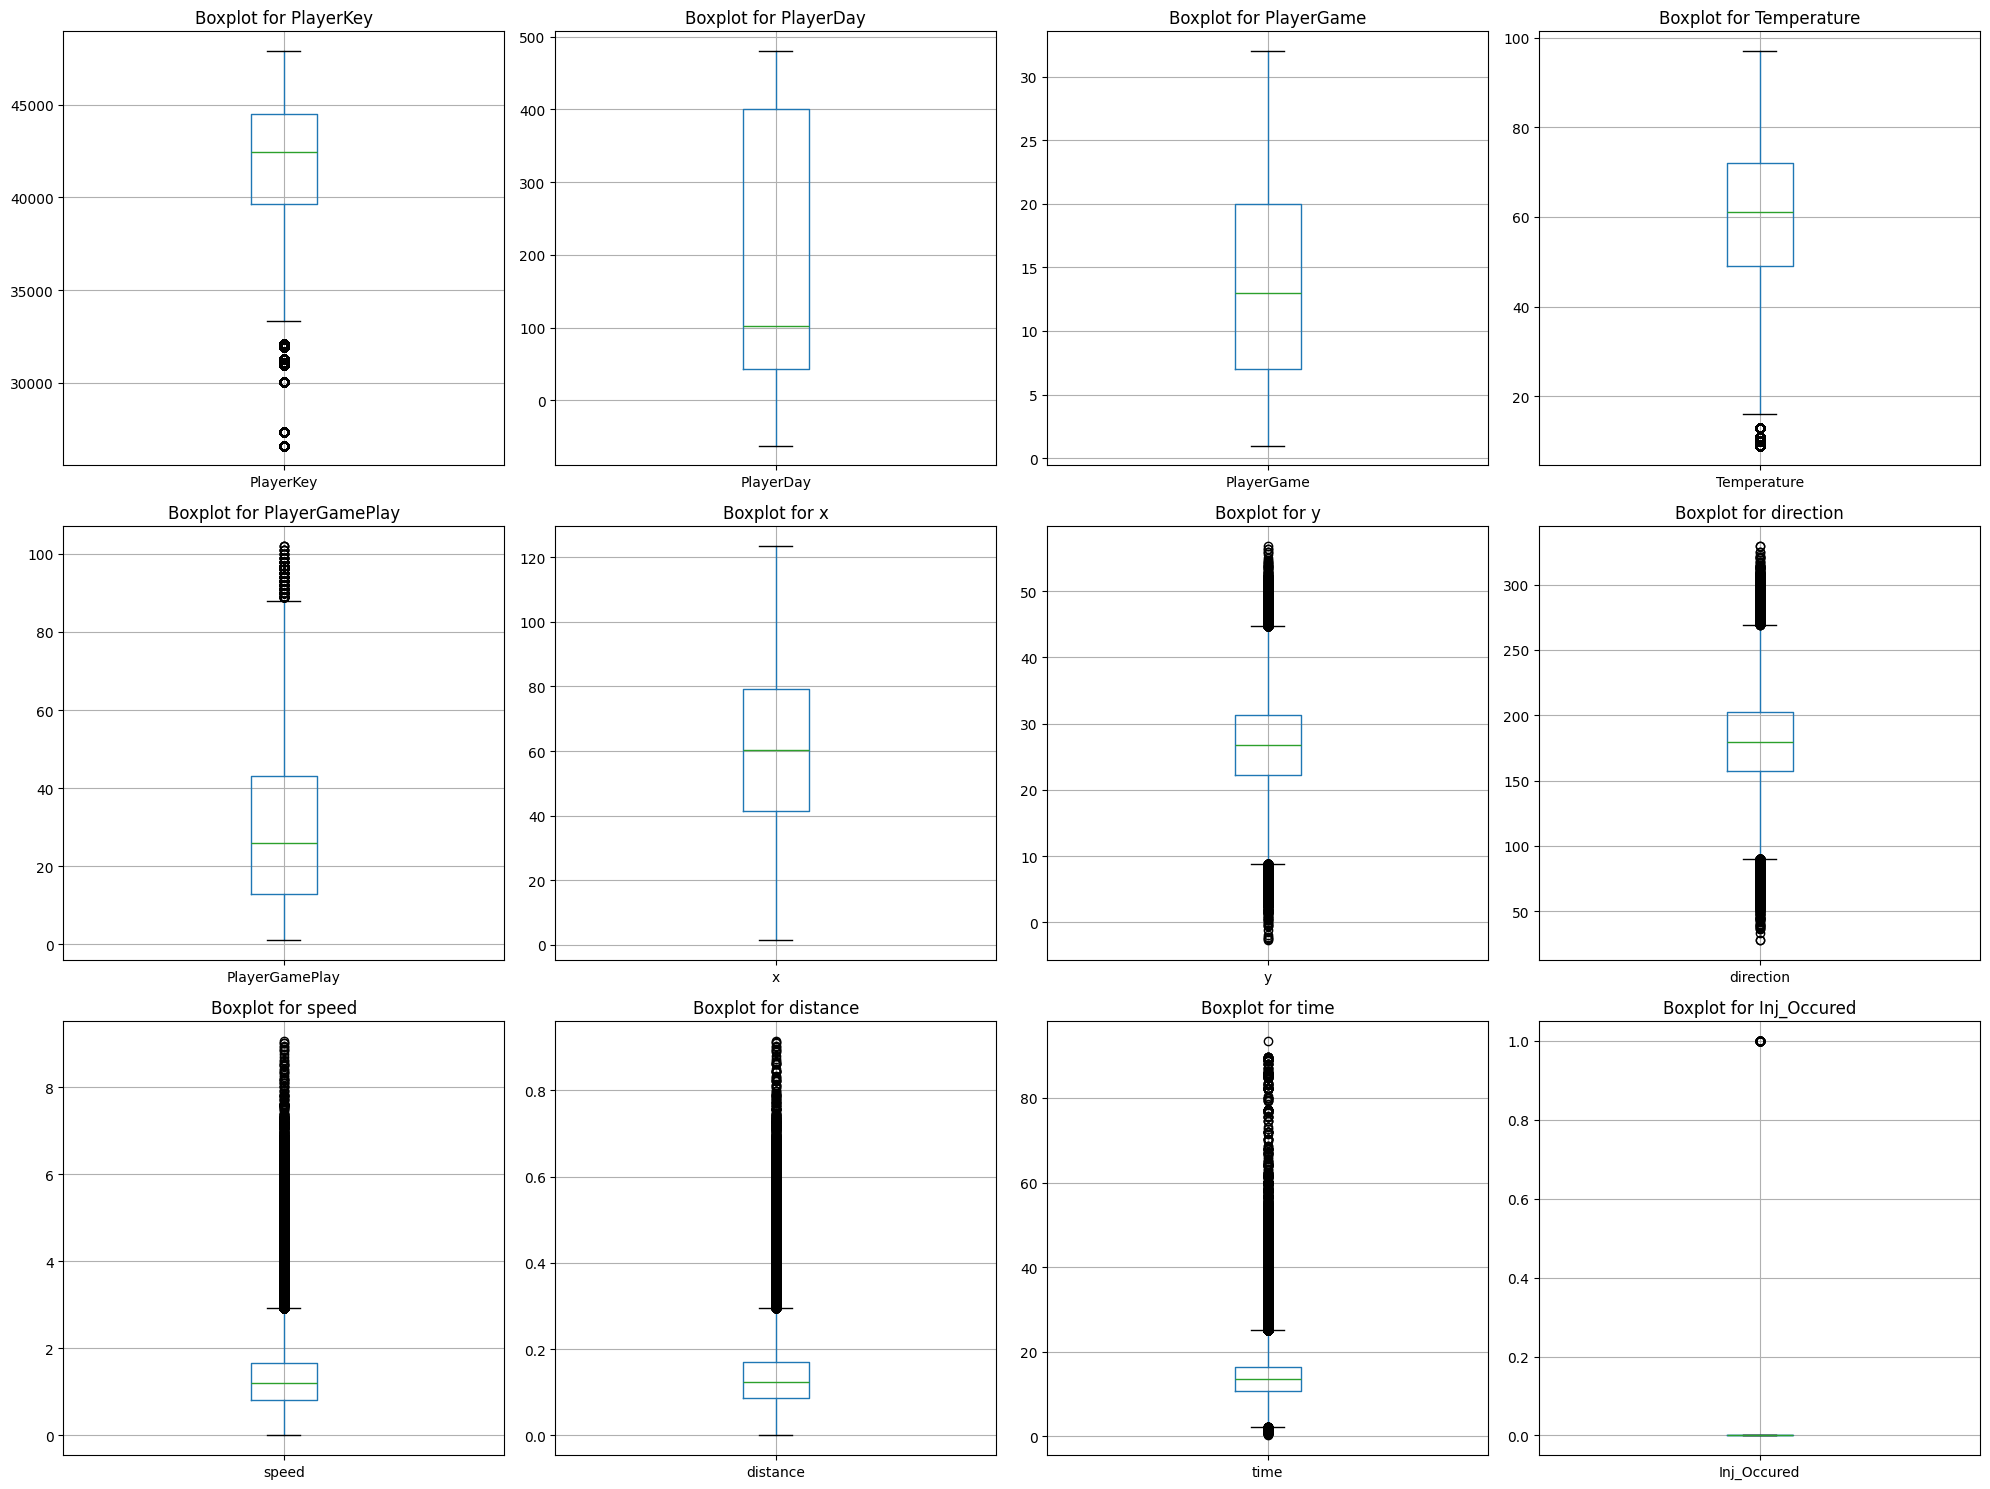

In [33]:
boxplots(All_Plays_Numeric)

#### Plays with Injuries

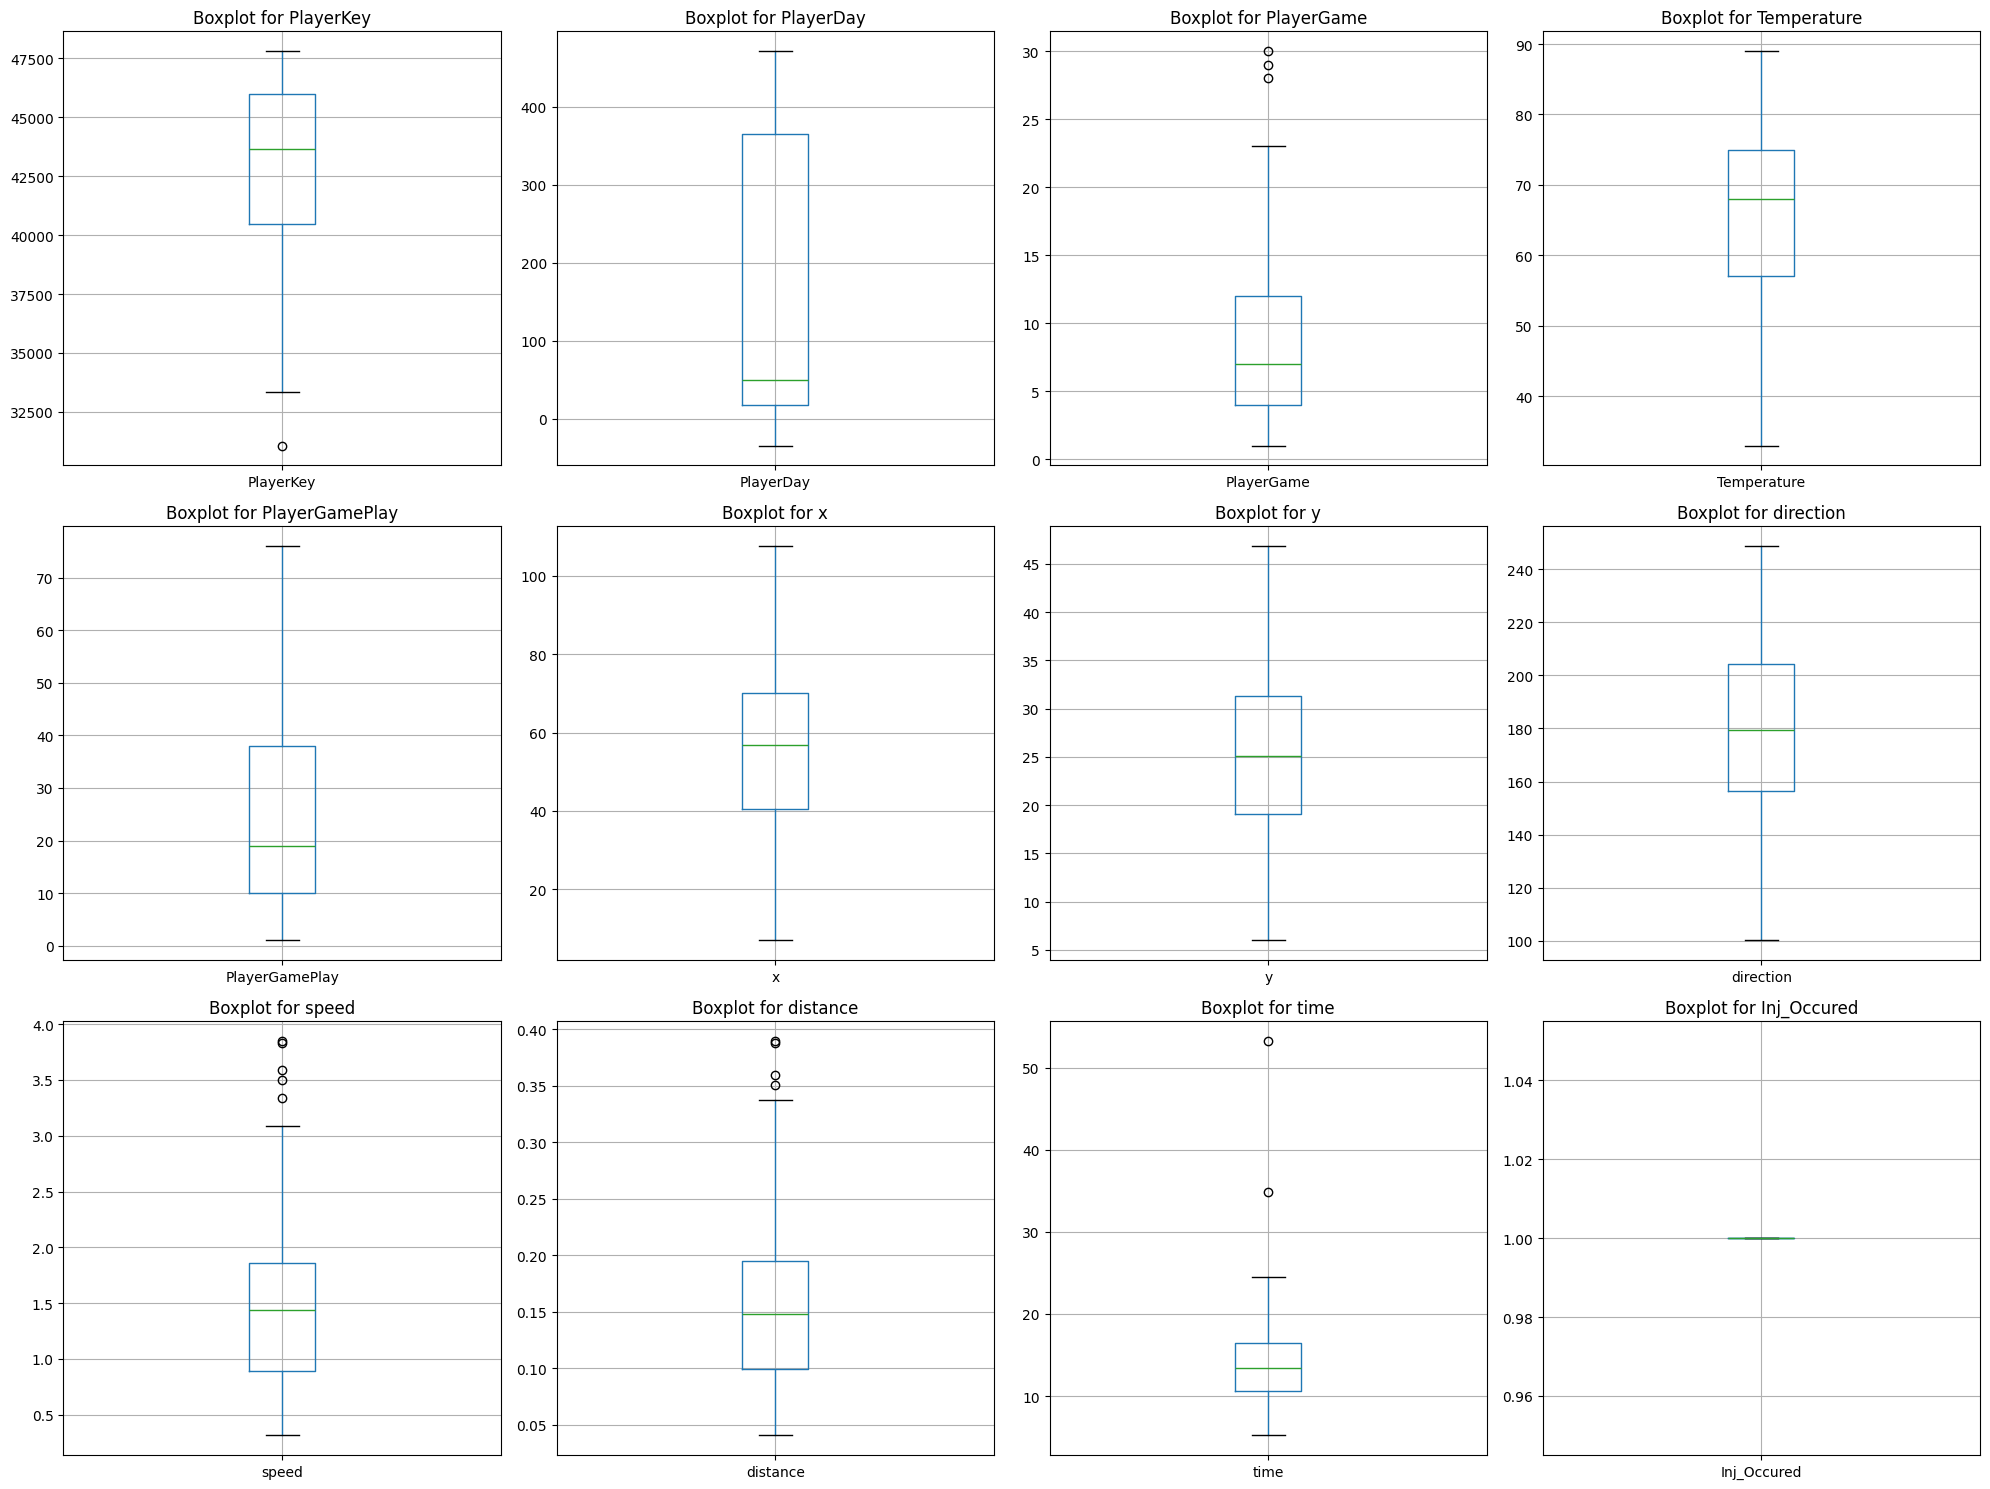

In [34]:
boxplots(Merged_Injury_Numeric)

___

In [35]:
def mean_median_mode(df):
    categorical_columns = []  
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):  
            print(f"Column Name: {col}")
            print(f"Mean: {df[col].mean():.2f}")
            print(f"Median: {df[col].median()}")

            mode_values = df[col].mode()
            mode_display = mode_values[0] if not mode_values.empty else "No Mode"
            print(f"Mode: {mode_display}")
            print()
            print("-" * 30)

        else:
            categorical_columns.append(col)

    print(f"Categorical Columns: {categorical_columns}")

In [36]:
mean_median_mode(All_Plays)

Column Name: PlayerKey
Mean: 41515.40
Median: 42432.0
Mode: 44480

------------------------------
Column Name: PlayerDay
Mean: 210.45
Median: 102.0
Mode: 1

------------------------------
Column Name: PlayerGame
Mean: 13.80
Median: 13.0
Mode: 8

------------------------------
Column Name: Temperature
Mean: 60.92
Median: 61.0
Mode: 61

------------------------------
Column Name: PlayerGamePlay
Mean: 29.06
Median: 26.0
Mode: 1

------------------------------
Column Name: x
Mean: 60.17
Median: 60.272779456193355
Mode: 51.25

------------------------------
Column Name: y
Mean: 26.75
Median: 26.757130177514792
Mode: 23.91

------------------------------
Column Name: direction
Mean: 179.79
Median: 179.7870353982301
Mode: 177.225

------------------------------
Column Name: speed
Mean: 1.33
Median: 1.1987456445993032
Mode: 0.0

------------------------------
Column Name: distance
Mean: 0.14
Median: 0.12480132450331125
Mode: 0.13

------------------------------
Column Name: time
Mean: 14.27
Me

## **Univariate Analysis Overview**

### Here are some types of analysis you can do  Use Google, documentation, and ChatGPT to help you:

**1) Summarize the datasets using info() and describe()**

There are 22 columns and 267,006 rows in the dataset -- a majority of the rows are almost completely filled out with hardly any nulls. The only exception to this is the precense of three columns: 
- BodyPart
- Surface
- InjuryLength

That are only filled out in the presense of injuries. This means that each of these columns only has 77 non-null values. Additionally, I want to make it clear that this dataset is significantly larger than the other NFL datasets studied, with this dataset registering that there were over 260,000 plays over a 1 year period, while other datasets said the number of plays over a 1 year period was much lower. 

Additionally, when this dataset was filtered by playType to 'Punt' plays only, It had registered approaximately twice as many plays as the NFL Punt Return dataset -- this is remarkable because the NFL punt dataset was collected over a period that was over twice as long. 

**2) Are there any duplicate rows?**

There are no duplicated rows in this dataset.

**3) Are there any duplicate values in a given column (when this would be inappropriate?)**

There are multiple columns in the dataset that contain a number of duplicated columns. This makes sense as these are either categorical columns where the value is enumerated over a list of a set amount of values -- or the data is numeric and will only take a value in a limited range of values. 

**4) What are the mean, median, and mode of each column?**

This is detailed in cell [38]. 

**5) Are there any missing or null values?**

Yes, there are a number of missing / null values in three columns as talked about above: 

- BodyPart
- Surface
- InjuryLength

Only have 77 filled values while the rest of the columns are almost completely filled. This is because these fields are only filled out when an injury is registered, which only happend 77 / 260,000 times in this dataset. 


-   **5.a) Do you want to fill in the missing value with a mean value?  A value of your choice?  Remove that row?**

For the null values in this case, I will probably just fill them with a N/A value. 

**6) Identify any other inconsistent data (e.g. someone seems to be taking an action before they are born.)**

As evidenced above, this dataset registers a strinking number more plays per NFL season than the other datasets do. And this happens to such a degree that it is rather suspicous. I think that I need to look a lot closer into why the number of plays in this particular NFL season is roughly 5x more than previous seasons as evidenced by those datasets. 


**7) Encode any categorical variables (e.g. with one-hot encoding.)**

Because of the large amount of categorical variables in this dataset, One- Hot encoding will not take place if and until it is determined that the variable in question has a direct impact on Injury Prevalence, our target variable. 


### **Conclusions:**

**8) Are the data usable?  If not, find some new data!**

Despite the limitations of this dataset and the issues discussed above, I still think that it is a very powerful dataset that we can use to investigate Injuries in the NFL. 

**9) Do you need to modify or correct the data in some way?**

Yes -- Our Action items are as follows: 

- Investigate the Disparity between the number of records in this dataset and other datasets.
- Correct the class imbalances between player injury prevalence and non-injury plays to allow for proper BiVariate analysis. 
- Correct the number of Null fields that occur in the Injury-Type columns. 

**10) Is there any class imbalance?  (Categories that have many more items than other categories).**

Yes, as we are investigating injuries, and according to this dataset, the injury rate is 00.03% in any given play, there is a large imbalance between plays where injuries occured and plays where injuried did not occur.

Becuase of this, it is extemely difficult to accertain which variables are correlated with injury prevalence because injury prevalence is so low that it is effectively considered noise by most types of statistical analysis. We will need to correct this before moving forward. 


____

# Bivariate Analysis

In [37]:
def corr_heatmap(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(),
                annot=True,
                fmt=".2f", 
                cmap="coolwarm",
                linewidths=0.5)
    plt.title(f"Correlation Heatmap")
    plt.show()

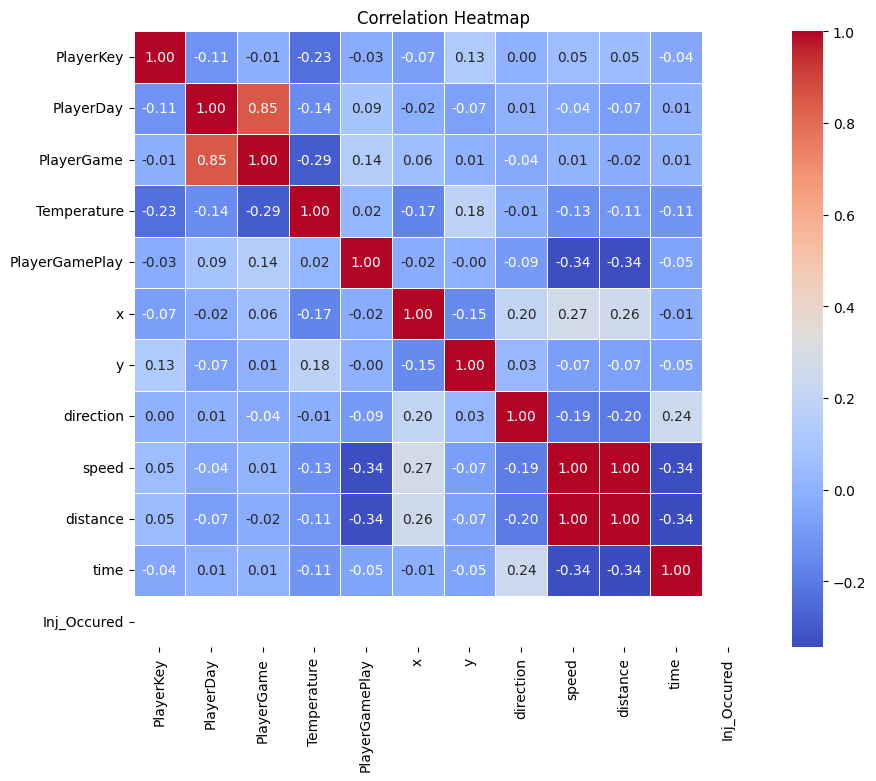

In [38]:
corr_heatmap(Merged_Injury_Numeric)

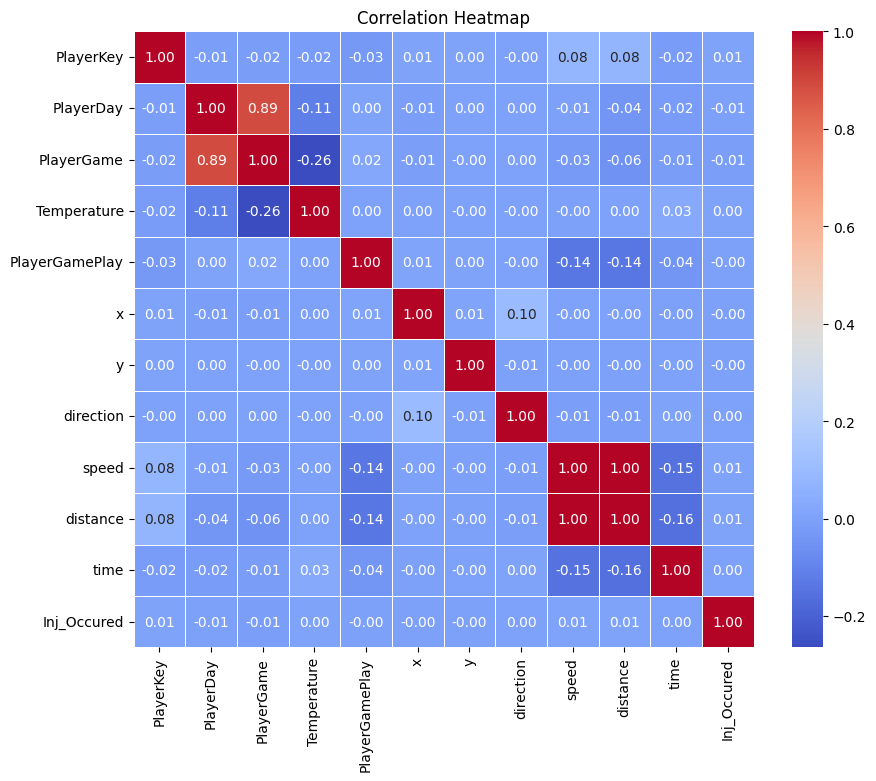

In [39]:
corr_heatmap(All_Plays_Numeric)

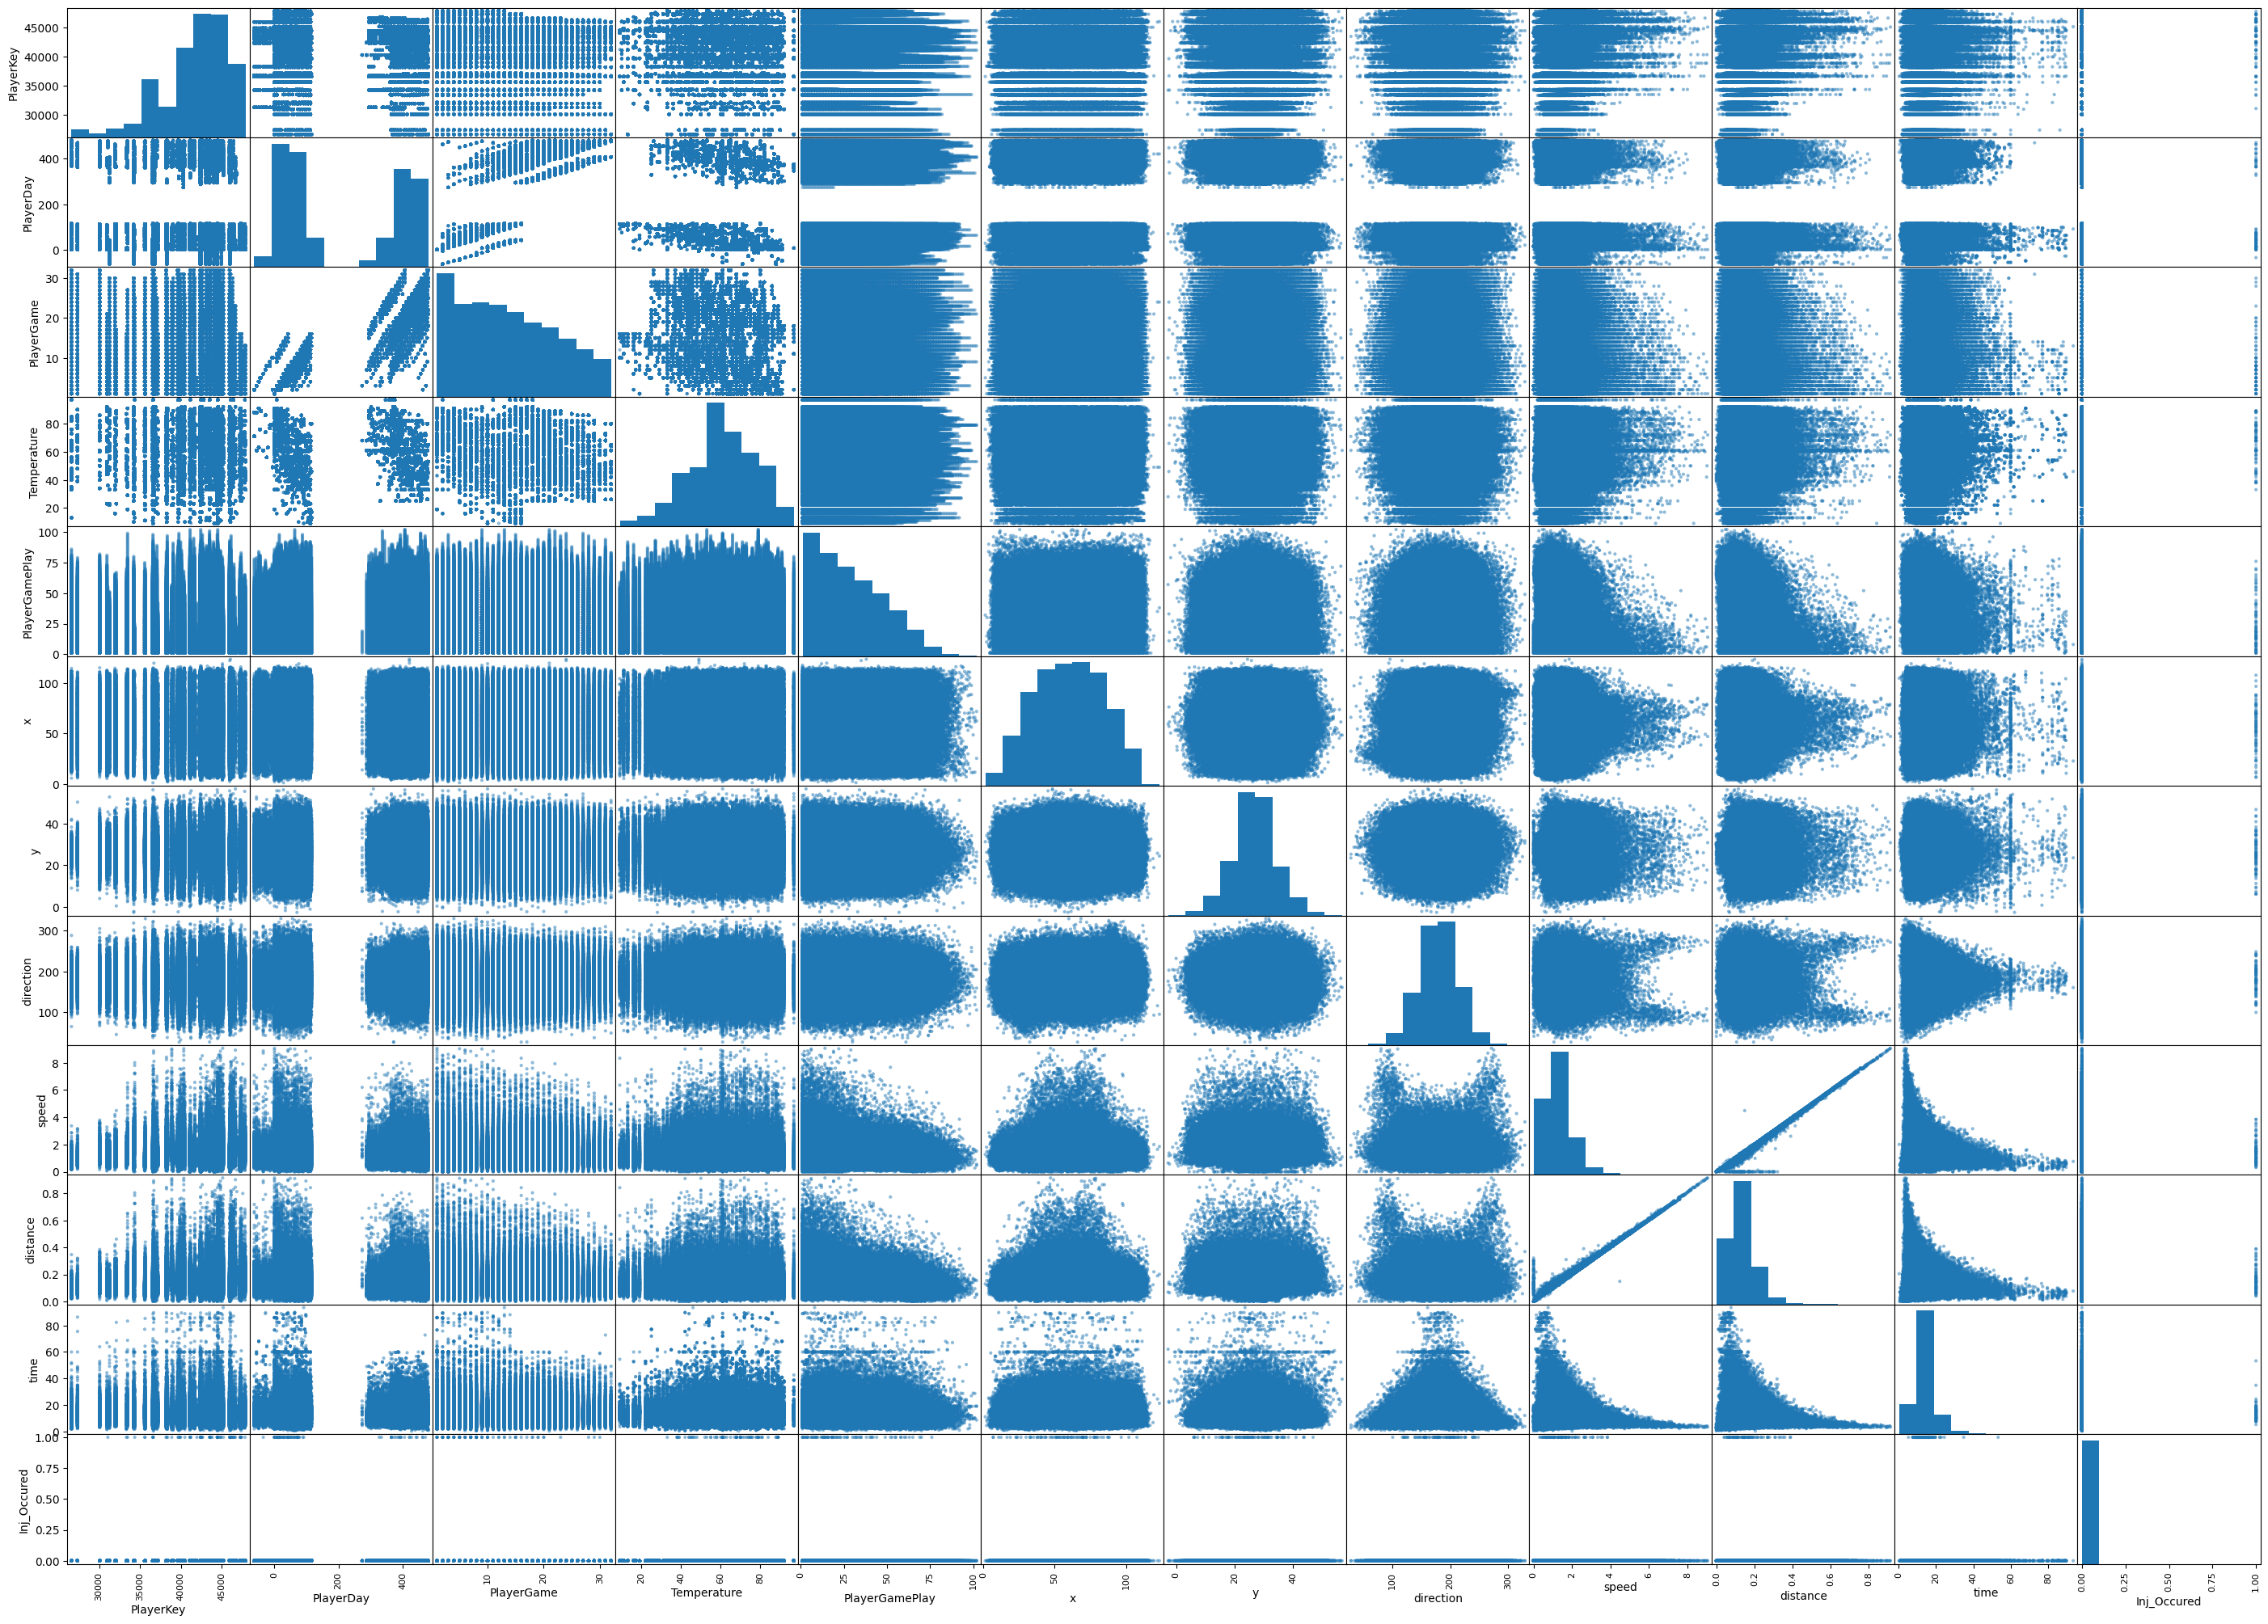

In [40]:
axes = pd.plotting.scatter_matrix(
    All_Plays_Numeric,
    c=None,
    alpha=0.5,
    figsize=(35, 25),
    diagonal='hist', 
)
for ax in axes.flatten():
    ax.tick_params(axis="y", labelsize=10) 

plt.show()

# *Conclusions:*

**- Explain what conclusions you would draw from this analysis: are the data what you expect?  Are the data likely to be usable?  If the data are not useable, find some new data!**


Right now, we cannot draw any conclusions from this dataset as the class imbalances are too intense for us to draw any meaningful relationships between the datapoints. 



**- Do you see any outliers?  (Data points that are far from the rest of the data).**


In my Univariate analysis of the All_Plays dataset, there were outliers for: 

- Temperature (low end)
- x (low end and high end)
- y (low end and high end)
- Speed (high end)
- distance (high end)
- time on play (high end)

These outliers are not concerning as all of these can easily be explained by common phenomina in football. i.e. Most games occur at a relative temperature but some occur at much lower termperatures, even snow storms. 

Most plays happen in the middle of the field but some happen on the extremities of the field (x and y)

Most plays are for a relatively low yard gain but others will have a high yard gain when a player breaks away. 

Most plays will avereage out over a certain number of seconds but some will take place over a much larger interval. 

**- Are any data items highly correlated with each other, suggesting that they are redundant?**

- There were some really high correlations between PlayerDay and PlayerGame. We should keep an eye on these columns and make sure to deal with them moving forward before we think about building any models from the data. Additionally, there were correlations between speed, play time (how long a particular play took) and distance which make sense logically. (Plays where there was a significant yardage gain typically took longer to carry out and the players also generally will register greater speeds during these plays (As opposed to getting tackled at the line of scrimmage, etc.))



**- For the line plots, do you see a trend or pattern over time?  Does this suggest that the data are changing over time (drifting) in such a way as to invalidate comparisons?**

- This question isn’t entirely applicable to our dataset, as we are not tracking injuries over time. Instead, we are analyzing injuries from a single NFL season to identify trends and factors that may contribute to injury prevalence. When it comes to different types of plays, the only time variable is really the amount of time that a particular play took which doesn't have a correlation to Injury Prevalance which is the main thing that we are interested in. 

**- Can you think of any confounding variables?  (Third variables that could explain any correlations between other variables.  These third variables may or may not be reported in the dataset.)**

- The only confounding variable that I can think of here would possibly be time as it's related to both the distance that a player was able to accumulate during a play and the speed that a player was able to reach during a play. All of these variables had correlation coefficients of 0.00 to the injury occurance target variable so I will likely just drop these columns before any model is made rather than deal with the confounding effects. 

In [41]:
len(Merged_Injury)

77

In [48]:
Merged_Injury

PlayKey BodyPart    Surface InjuryLength  PlayerKey  PlayerDay  \
0    39873-4-32     Knee  Synthetic          42+      39873         29   
1    46074-7-26     Knee    Natural           7+      46074         50   
2    36557-1-70    Ankle  Synthetic          42+      36557          1   
3    46646-3-30    Ankle    Natural           1+      46646         15   
4    43532-5-69    Ankle  Synthetic          42+      43532         32   
..          ...      ...        ...          ...        ...        ...   
72  42418-19-15    Ankle  Synthetic           1+      42418        442   
73   46394-18-3     Knee  Synthetic           7+      46394        393   
74    45187-9-4    Ankle    Natural           1+      45187        327   
75   42448-14-3     Knee  Synthetic          28+      42448        379   
76    47334-8-1     Knee  Synthetic           7+      47334         58   

    PlayerGame StadiumType  FieldType  Temperature  ... PlayerGamePlay  \
0            4     Indoors  Synthetic           84  ...             32   
1            7    Outdoors    Natural           76  ...             26   
2            1    Outdoors  Synthetic           63  ...             70   
3            3    Outdoors    Natural           80  ...             30   
4            5     Indoors  Synthetic           89  ...             69   
..         ...         ...        ...          ...  ...            ...   
72          19     Indoors  Synthetic           57  ...             15   
73          18    Outdoors  Synthetic           45  ...              3   
74           9    Outdoors    Natural           81  ...              4   
75          14     Indoors  Synthetic           78  ...              3   
76           8     Indoors  Synthetic           74  ...              1   

   Position  PositionGroup          x          y   direction     speed  \
0       OLB     LineBacker  70.364027  29.741018  189.061222  1.489140   
1       OLB     LineBacker  65.712646  26.073991  144.081300  2.024215   
2        SS  DefensiveBack  79.455250  23.267500  156.608563  1.574938   
3        LB     LineBacker  50.998280  26.180320  126.469440  2.194320   
4        WR   WideReciever  65.598514  46.844857  164.235943  0.760543   
..      ...            ...        ...        ...         ...       ...   
72        C  OffensiveLine  59.343956  23.616075  214.237321  0.654237   
73       TE       TightEnd  56.389781  41.013443  217.776175  2.673880   
74       WR   WideReciever  16.601672  16.926972  138.652555  1.616782   
75       WR   WideReciever  53.226865   7.361027  147.681135  2.284649   
76       DB  DefensiveBack  56.815567  34.524381  240.235567  3.588093   

    distance   time  Inj_Occured  
0   0.160837  22.05            1  
1   0.210269  11.10            1  
2   0.168875   7.95            1  
3   0.237160  12.45            1  
4   0.087743  17.45            1  
..       ...    ...          ...  
72  0.068380  16.00            1  
73  0.267596  18.25            1  
74  0.163943  15.80            1  
75  0.233351   9.20            1  
76  0.359691   9.65            1  

[77 rows x 22 columns]

In [ ]:
All_Plays.to_csv()

PlayKey BodyPart Surface InjuryLength  PlayerKey  PlayerDay  \
0         26624-1-1      NaN     NaN          NaN      26624          1   
1         26624-1-2      NaN     NaN          NaN      26624          1   
2         26624-1-3      NaN     NaN          NaN      26624          1   
3         26624-1-4      NaN     NaN          NaN      26624          1   
4         26624-1-5      NaN     NaN          NaN      26624          1   
...             ...      ...     ...          ...        ...        ...   
267001  47888-13-51      NaN     NaN          NaN      47888         99   
267002  47888-13-52      NaN     NaN          NaN      47888         99   
267003  47888-13-53      NaN     NaN          NaN      47888         99   
267004  47888-13-54      NaN     NaN          NaN      47888         99   
267005  47888-13-55      NaN     NaN          NaN      47888         99   

        PlayerGame StadiumType  FieldType  Temperature  ... PlayerGamePlay  \
0                1    Outdoors  Synthetic           63  ...              1   
1                1    Outdoors  Synthetic           63  ...              2   
2                1    Outdoors  Synthetic           63  ...              3   
3                1    Outdoors  Synthetic           63  ...              4   
4                1    Outdoors  Synthetic           63  ...              5   
...            ...         ...        ...          ...  ...            ...   
267001          13    Outdoors  Synthetic           33  ...             51   
267002          13    Outdoors  Synthetic           33  ...             52   
267003          13    Outdoors  Synthetic           33  ...             53   
267004          13    Outdoors  Synthetic           33  ...             54   
267005          13    Outdoors  Synthetic           33  ...             55   

       Position  PositionGroup          x          y   direction     speed  \
0            QB    QuarterBack  87.665753  28.221104  186.148361  0.535753   
1            QB    QuarterBack  86.616462  29.144077  211.949423  0.849692   
2            QB    QuarterBack  79.677264  28.900203  194.134122  0.331014   
3            QB    QuarterBack  72.469449  26.680157  163.762205  0.523701   
4            QB    QuarterBack  65.407846  24.865577  222.120577  0.970385   
...         ...            ...        ...        ...         ...       ...   
267001       DB  DefensiveBack  41.700296  18.853989  155.077709  1.229191   
267002       DB  DefensiveBack  53.980678  18.102780  169.963559  1.796203   
267003       DB  DefensiveBack  57.170638  10.130479  181.141330  1.806649   
267004       DB  DefensiveBack  54.662095  18.973687  166.529609  2.147682   
267005       DB  DefensiveBack  73.845399  25.883113  190.421322  1.465234   

        distance   time  Inj_Occured  
0       0.056288  14.90            0  
1       0.090077  12.95            0  
2       0.036081  14.75            0  
3       0.054016   6.30            0  
4       0.099769  12.95            0  
...          ...    ...          ...  
267001  0.124582  18.50            0  
267002  0.180780  14.70            0  
267003  0.182394   9.35            0  
267004  0.215279  17.85            0  
267005  0.147521  18.10            0  

[267006 rows x 22 columns]

___

# **Data Remediations**

To address the class imbalance described above, we implemented undersampling of injury plays. While oversampling was considered, it was ultimately avoided to prevent excessive duplication of a small dataset—especially given the extreme imbalance (e.g., only 100 injuries in a dataset of over 260,000 plays).

The following code was taken and adapted from ChatGPT: 
- https://chatgpt.com/share/67c9d8c4-b23c-800f-bb50-7475bf8c0d3a


Steps to oversample the injury data were taken out for this analysis. 

In [42]:
from imblearn.under_sampling import RandomUnderSampler


injury_col = 'Inj_Occured'  


injury_plays = All_Plays[All_Plays[injury_col] == 1]
non_injury_plays = All_Plays[All_Plays[injury_col] == 0]

# Undersample non-injury plays (optional, keeping 3x injuries for balance)
undersample_ratio = 3 * len(injury_plays) 
non_injury_plays_sampled = non_injury_plays.sample(n=undersample_ratio, random_state=42)

# Combine undersampled non-injury plays with all injuries
balanced_df = pd.concat([injury_plays, non_injury_plays_sampled])


print("Resampled dataset shape:", balanced_df[injury_col].value_counts())


Resampled dataset shape: Inj_Occured
0    231
1     77
Name: count, dtype: int64


In [43]:
balanced_df_numeric = balanced_df.select_dtypes(include=['number'])
balanced_df_categorical = balanced_df.select_dtypes(exclude=['number'])

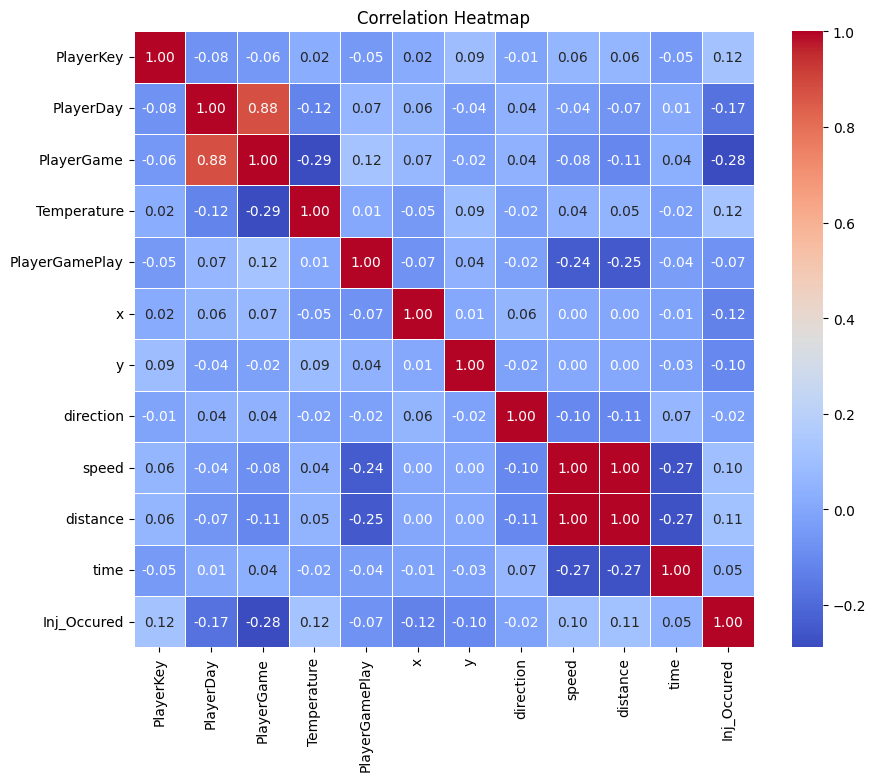

In [44]:
corr_heatmap(balanced_df_numeric)

Looking into the rebalanced dataset, it looks like PlayerGame was the most correlated with Injury Occurance. Although the Next Gen Statistics (NGS Stats) were added into this analysis, they did not yield any significant correlations compared to the target variable. 

In [45]:

def chi_square_test(df, target='Inj_Occured'):
    y = df[target]  # Boolean column
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns  # Select categorical columns

    results = {}
    for col in categorical_cols:
        table = pd.crosstab(df[col], y)  # Create contingency table
        chi2, p, dof, expected = stats.chi2_contingency(table)  # Perform Chi-Square test
        results[col] = p * 100 # Store p-value * 100 for readability

    return results  

In [46]:
p_values = chi_square_test(balanced_df)

print("===== Unlikely Correlated to Injury Occurrence ===== \n")
for col, p in sorted(p_values.items(), key=lambda x: x[1], reverse=True):  
    if p >= 30:  
        print(f"p-value ({col}): {p:.2f}% (Correlation likely due to chance)")

print("\n\n===== Most Likely Correlated to Injury Occurrence ===== \n")
for col, p in sorted(p_values.items(), key=lambda x: x[-1], reverse=True):  
    if p < 30:  
        print(f"p-value ({col}): {p:.2f}% ('Significant' correlation)")

===== Unlikely Correlated to Injury Occurrence ===== 

p-value (BodyPart): 100.00% (Correlation likely due to chance)
p-value (Surface): 100.00% (Correlation likely due to chance)
p-value (InjuryLength): 100.00% (Correlation likely due to chance)
p-value (StadiumType): 70.76% (Correlation likely due to chance)
p-value (PlayKey): 45.72% (Correlation likely due to chance)


===== Most Likely Correlated to Injury Occurrence ===== 

p-value (Weather): 25.28% ('Significant' correlation)
p-value (FieldType): 14.61% ('Significant' correlation)
p-value (Position): 14.34% ('Significant' correlation)
p-value (PositionGroup): 11.03% ('Significant' correlation)
p-value (PlayType): 0.40% ('Significant' correlation)


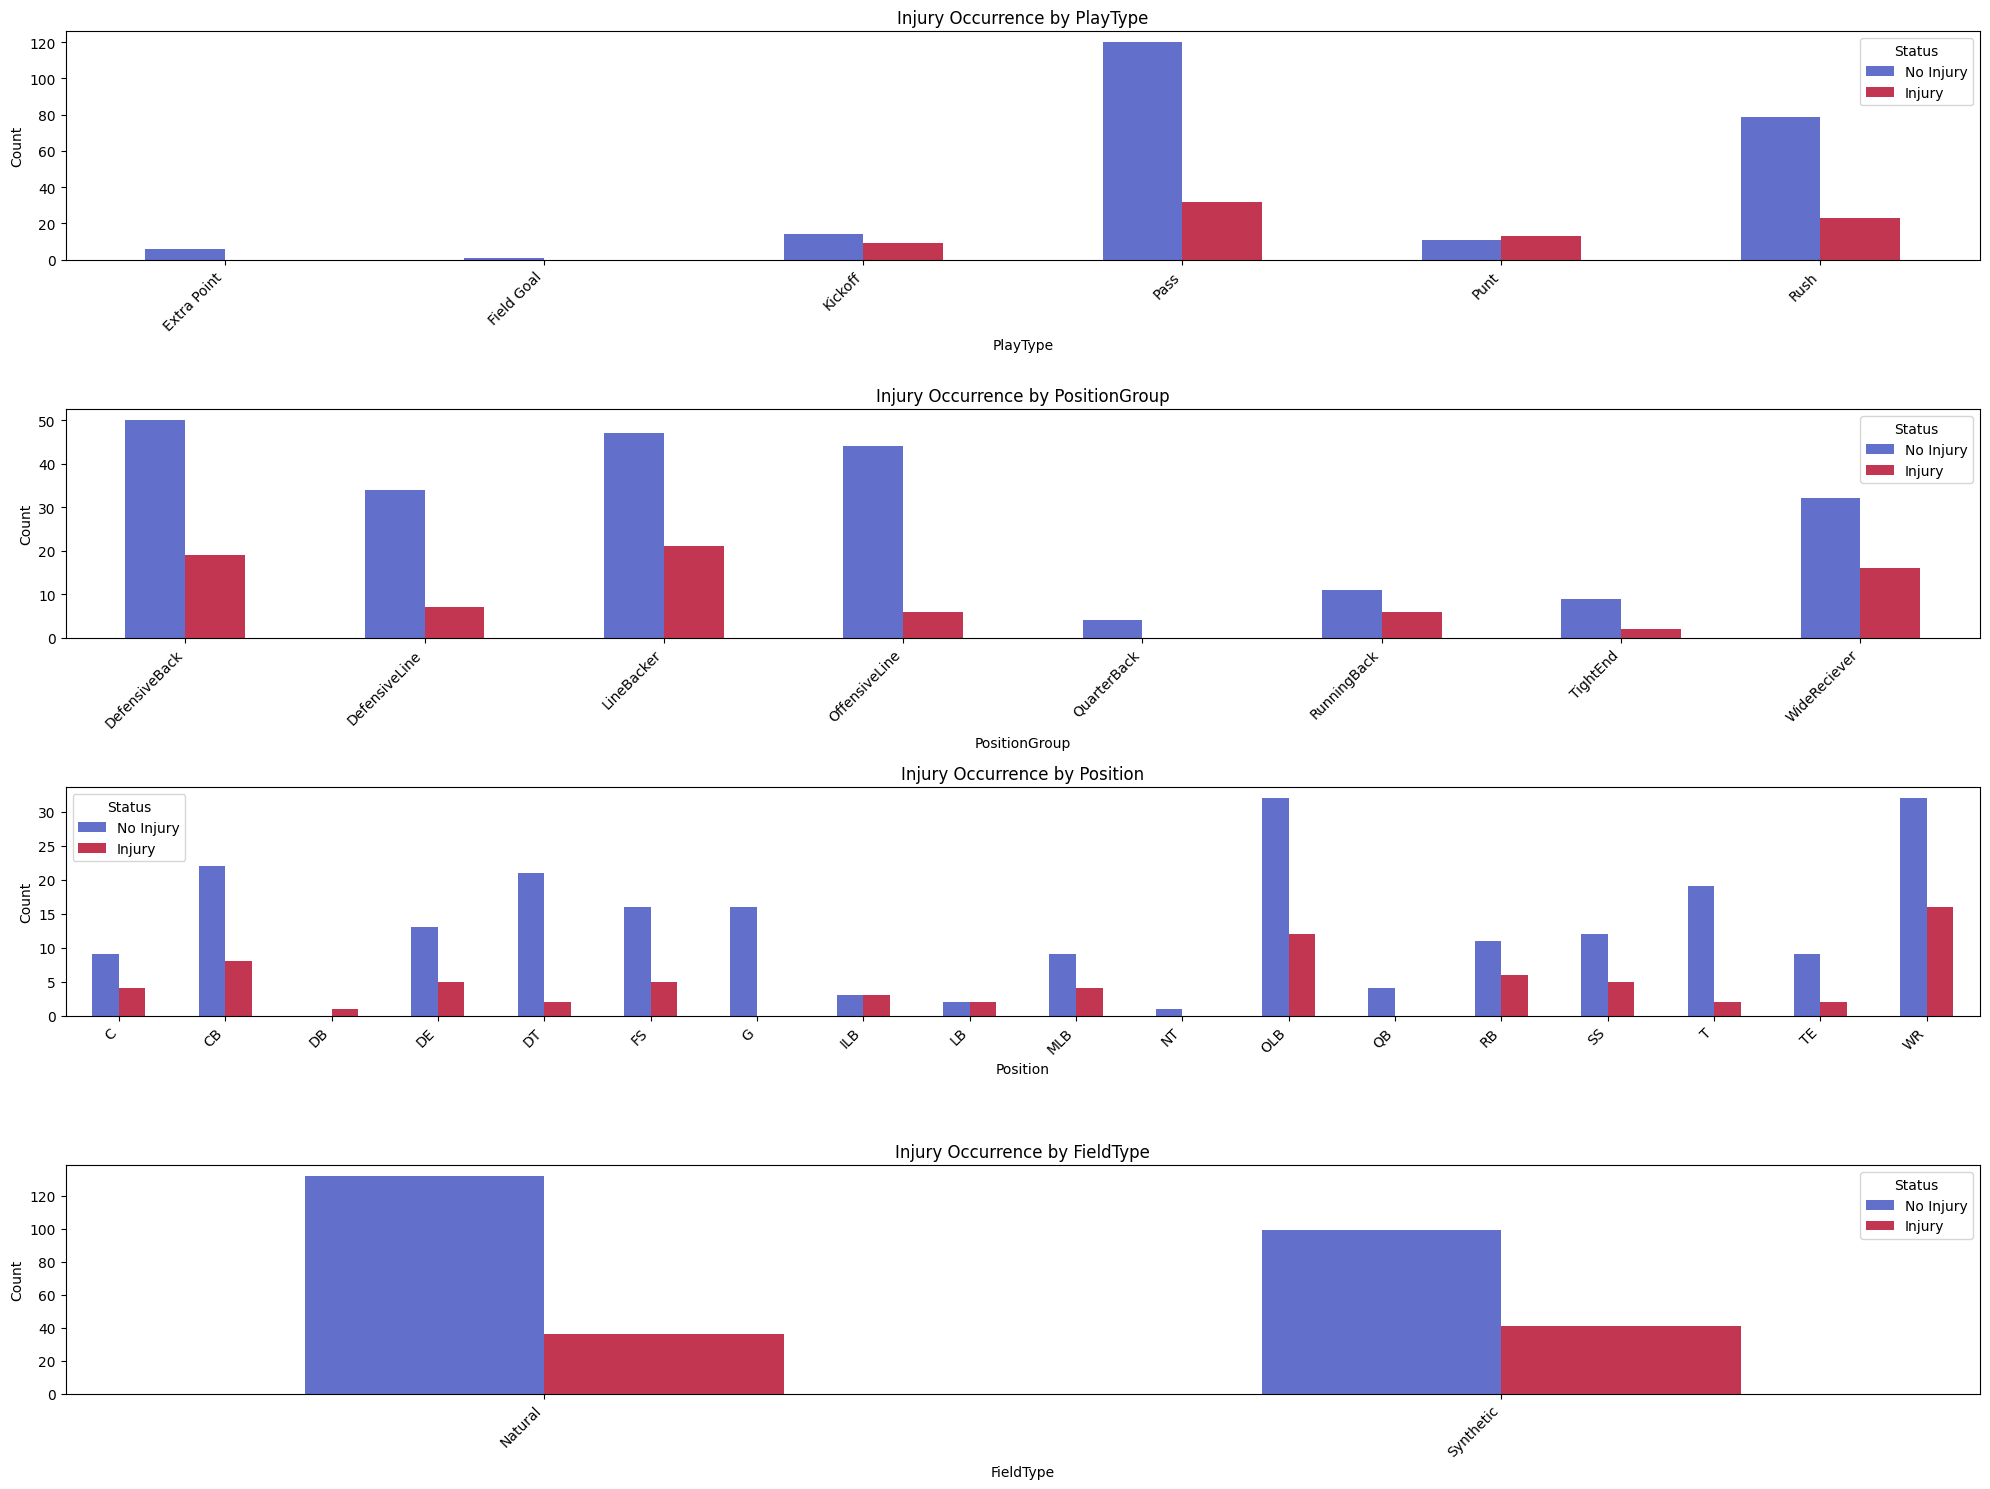

In [47]:
top_4_categorical_vars = sorted(p_values.items(), key=lambda x: x[1])[:5]  # 5 most significant
top_4_categorical_vars = [col for col, p in top_4_categorical_vars]  # Extract column names

fig, axes = plt.subplots(4, 1, figsize=(20, 15), sharey=False)  # Share y-axis for better comparison

# Iterate over top 4 categorical variables and plot them
for ax, col in zip(axes, top_4_categorical_vars):
    crosstab = pd.crosstab(balanced_df[col], balanced_df['Inj_Occured'])  # Get raw counts
    crosstab.plot(kind='bar', stacked=False, ax=ax, colormap='coolwarm', alpha=0.8)

    ax.set_title(f"Injury Occurrence by {col}")
    ax.set_ylabel("Count")  # Since we are using raw counts
    ax.set_xlabel(col)
    # ax.ylim(0, )
    ax.legend(["No Injury", "Injury"], title="Status")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt
plt.tight_layout()
plt.show()